In [55]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import time
from utils import *
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.calibration import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
### DATA LOAD ###

basedir = 'data/vehicles/'

# different folders have different sources for images e.g. GIT, Kitti
image_types = os.listdir(basedir)
cars = []

for imtype in image_types:
    cars.extend(glob.glob(basedir+imtype+'/*'))
    
print('Number of Vehicle Images found:', len(cars))
with open("cars.txt", 'w') as f:
    for fn in cars:
        f.write(fn+'\n')
        
#Do the same for non-vehicle images
basedir = 'data/non-vehicles/'
image_types = os.listdir(basedir)
notcars = []
for imtype in image_types:
    notcars.extend(glob.glob(basedir+imtype+'/*'))
print('Number of Non-Vehicle Images found:', len(notcars))
with open("notcars.txt", 'w') as f:
    for fn in notcars:
        f.write(fn+'\n')

Number of Vehicle Images found: 8792
Number of Non-Vehicle Images found: 8968


In [20]:
### GRAB RANDOM SINGLE CAR and NOT-CAR ###

# choose random car / not-car indices
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))

#read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

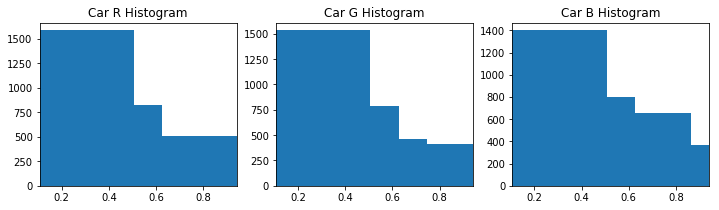

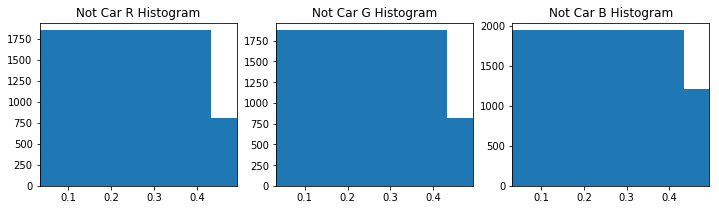

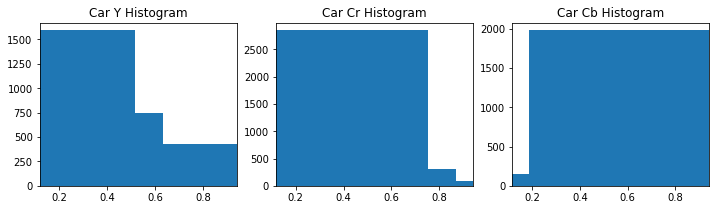

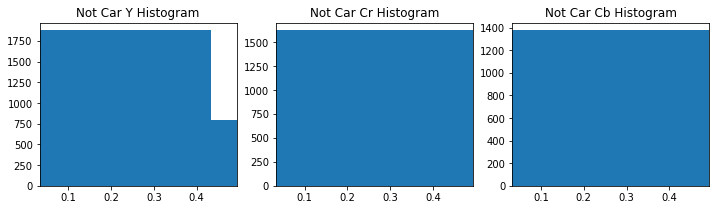

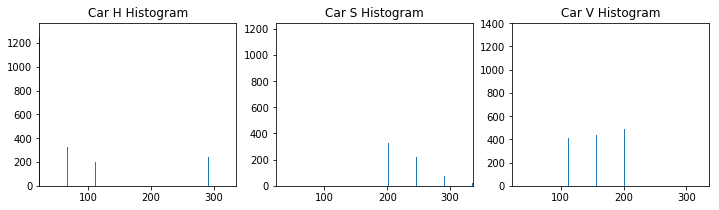

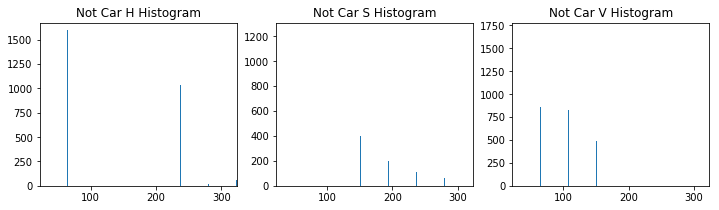

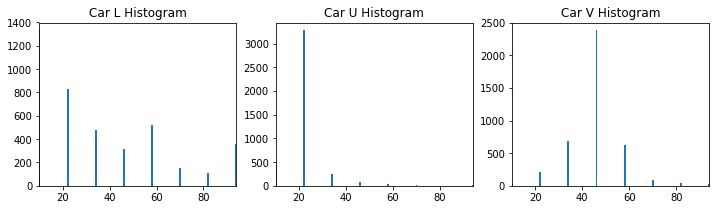

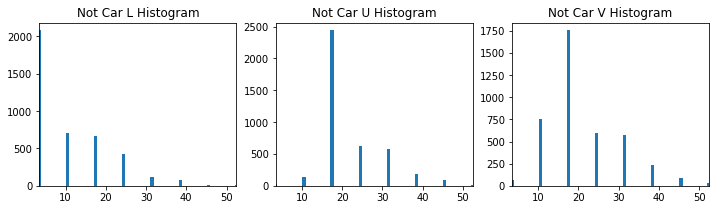

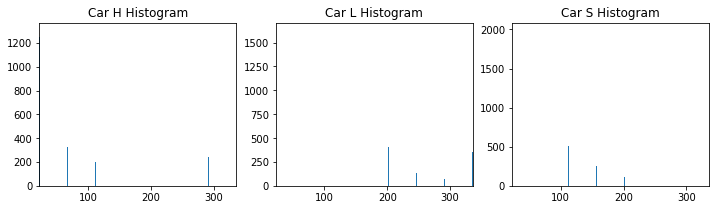

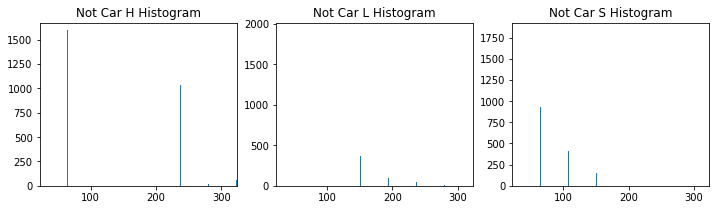

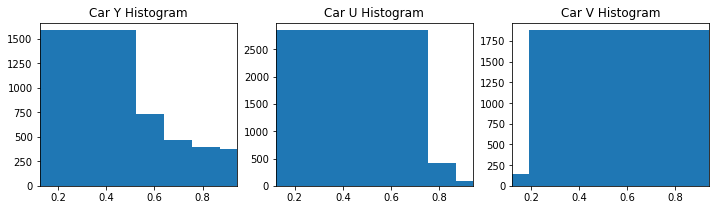

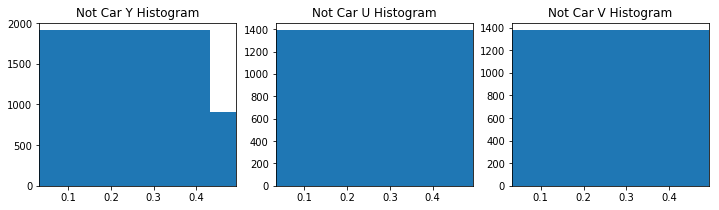

In [55]:
### VISUALIZE HISTOGRAM of COLOR CHANNELS in RGB ###

def visualHist(img, text, mode):
    modeText = {'RGB': ('R','G','B'),'HSV':('H','S','V'),
               'LUV':('L','U','V'), 'HLS':('H','L','S'),
               'YUV':('Y','U','V'),'YCrCb':('Y','Cr','Cb')}
    img = np.copy(img)
    img = color_mode(img,mode)

    # Generate histograms
    rhist = np.histogram(img[:,:,0], bins=8)
    ghist = np.histogram(img[:,:,1], bins=8)
    bhist = np.histogram(img[:,:,2], bins=8)
    
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2

    # Plot a figure with all three bar charts
    fig = plt.figure(figsize=(12,3))
    plt.subplot(131)
    plt.bar(bin_centers, rhist[0])
    plt.xlim(min(bin_centers), max(bin_centers))
    plt.title(text+' '+modeText[mode][0]+' Histogram')
    plt.subplot(132)
    plt.bar(bin_centers, ghist[0])
    plt.xlim(min(bin_centers), max(bin_centers))
    plt.title(text+' '+modeText[mode][1]+' Histogram')
    plt.subplot(133)
    plt.bar(bin_centers, bhist[0])
    plt.xlim(min(bin_centers), max(bin_centers))
    plt.title(text+' '+modeText[mode][2]+' Histogram')

visualHist(car_image,'Car','RGB')
visualHist(notcar_image,'Not Car','RGB')
visualHist(car_image,'Car','YCrCb')
visualHist(notcar_image,'Not Car','YCrCb')
visualHist(car_image,'Car','HSV')
visualHist(notcar_image,'Not Car','HSV')
visualHist(car_image,'Car','LUV')
visualHist(notcar_image,'Not Car','LUV')
visualHist(car_image,'Car','HLS')
visualHist(notcar_image,'Not Car','HLS')
visualHist(car_image,'Car','YUV')
visualHist(notcar_image,'Not Car','YUV')

In [49]:
# Experiment with Feature Parameters
color_space = 'YCrCb' # can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # can be 0, 1, 2, 'ALL'
spatial_size = (24, 24) # Spatial binning dimensions (downsizing)
hist_bins = 16 # number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

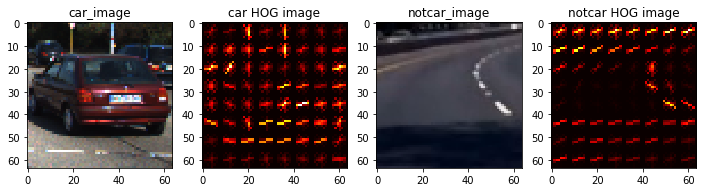

In [50]:
### Visualize effect of params on HOG for single image ###

# For visualization hog_channel will be set to 0

car_features, car_hog_image = single_img_features(car_image, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=0, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat, vis=True)
notcar_features, notcar_hog_image = single_img_features(notcar_image, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=0, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat, vis=True)


images = [car_image, car_hog_image, notcar_image, notcar_hog_image]
titles = ['car_image', 'car HOG image', 'notcar_image', 'notcar HOG image']
fig = plt.figure(figsize=(12,3))
visualize(fig, 1, 4, images, titles)

In [51]:
### TRAIN ON CLASSIFIER and output stats ###

## block for n-sample training data set
# n_samples = 500
# random_idxs = np.random.randint(0,len(cars), n_samples)
# cars = np.array(cars)[random_idxs]
# notcars = np.array(notcars)[random_idxs]

t = time.time() # start timer

# Extract features from cars and notcars
car_features = extract_features(cars, color_space=color_space,
                               spatial_size=spatial_size, hist_bins=hist_bins,
                               orient=orient, pix_per_cell=pix_per_cell,
                               cell_per_block=cell_per_block, hog_channel=hog_channel,
                               spatial_feat=spatial_feat, hist_feat=hist_feat,
                               hog_feat=hog_feat)

notcar_features = extract_features(notcars, color_space=color_space,
                               spatial_size=spatial_size, hist_bins=hist_bins,
                               orient=orient, pix_per_cell=pix_per_cell,
                               cell_per_block=cell_per_block, hog_channel=hog_channel,
                               spatial_feat=spatial_feat, hist_feat=hist_feat,
                               hog_feat=hog_feat)

print(time.time()-t, 'Seconds to compute features...')

X = np.vstack((car_features, notcar_features)).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X to Normalize the feature vectors
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split the data into randomized training and test sets
# don't need an intermediary Val set because the real end testing
# will be tracking performance on video output
rand_state = np.random.randint(0,100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y,
                                test_size=0.1, random_state=rand_state)
# Data print out of parameters
print('Using:',orient,'orientations,',pix_per_cell,'pixels per cell',
     cell_per_block,'cells per block',hist_bins,'hostogram bins, and',
     spatial_size,'spatial sampling')
print('Feature vector length:', len(X_train[0]))

# Using a linear SVC
svc = LinearSVC()
# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
print(round(time.time()-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

107.66077280044556 Seconds to compute features...
Using: 9 orientations, 8 pixels per cell 2 cells per block 16 hostogram bins, and (24, 24) spatial sampling
Feature vector length: 7068
7.89 Seconds to train SVC...
Test Accuracy of SVC =  0.9893


0.0 1.0
0.6171693801879883 seconds to process one image searching 100 windows
0.0 1.0
0.5922203063964844 seconds to process one image searching 100 windows
0.0 1.0
0.5506148338317871 seconds to process one image searching 100 windows
0.0 1.0
0.5627024173736572 seconds to process one image searching 100 windows
0.0 1.0
0.4872467517852783 seconds to process one image searching 100 windows
0.0 1.0
0.48723745346069336 seconds to process one image searching 100 windows


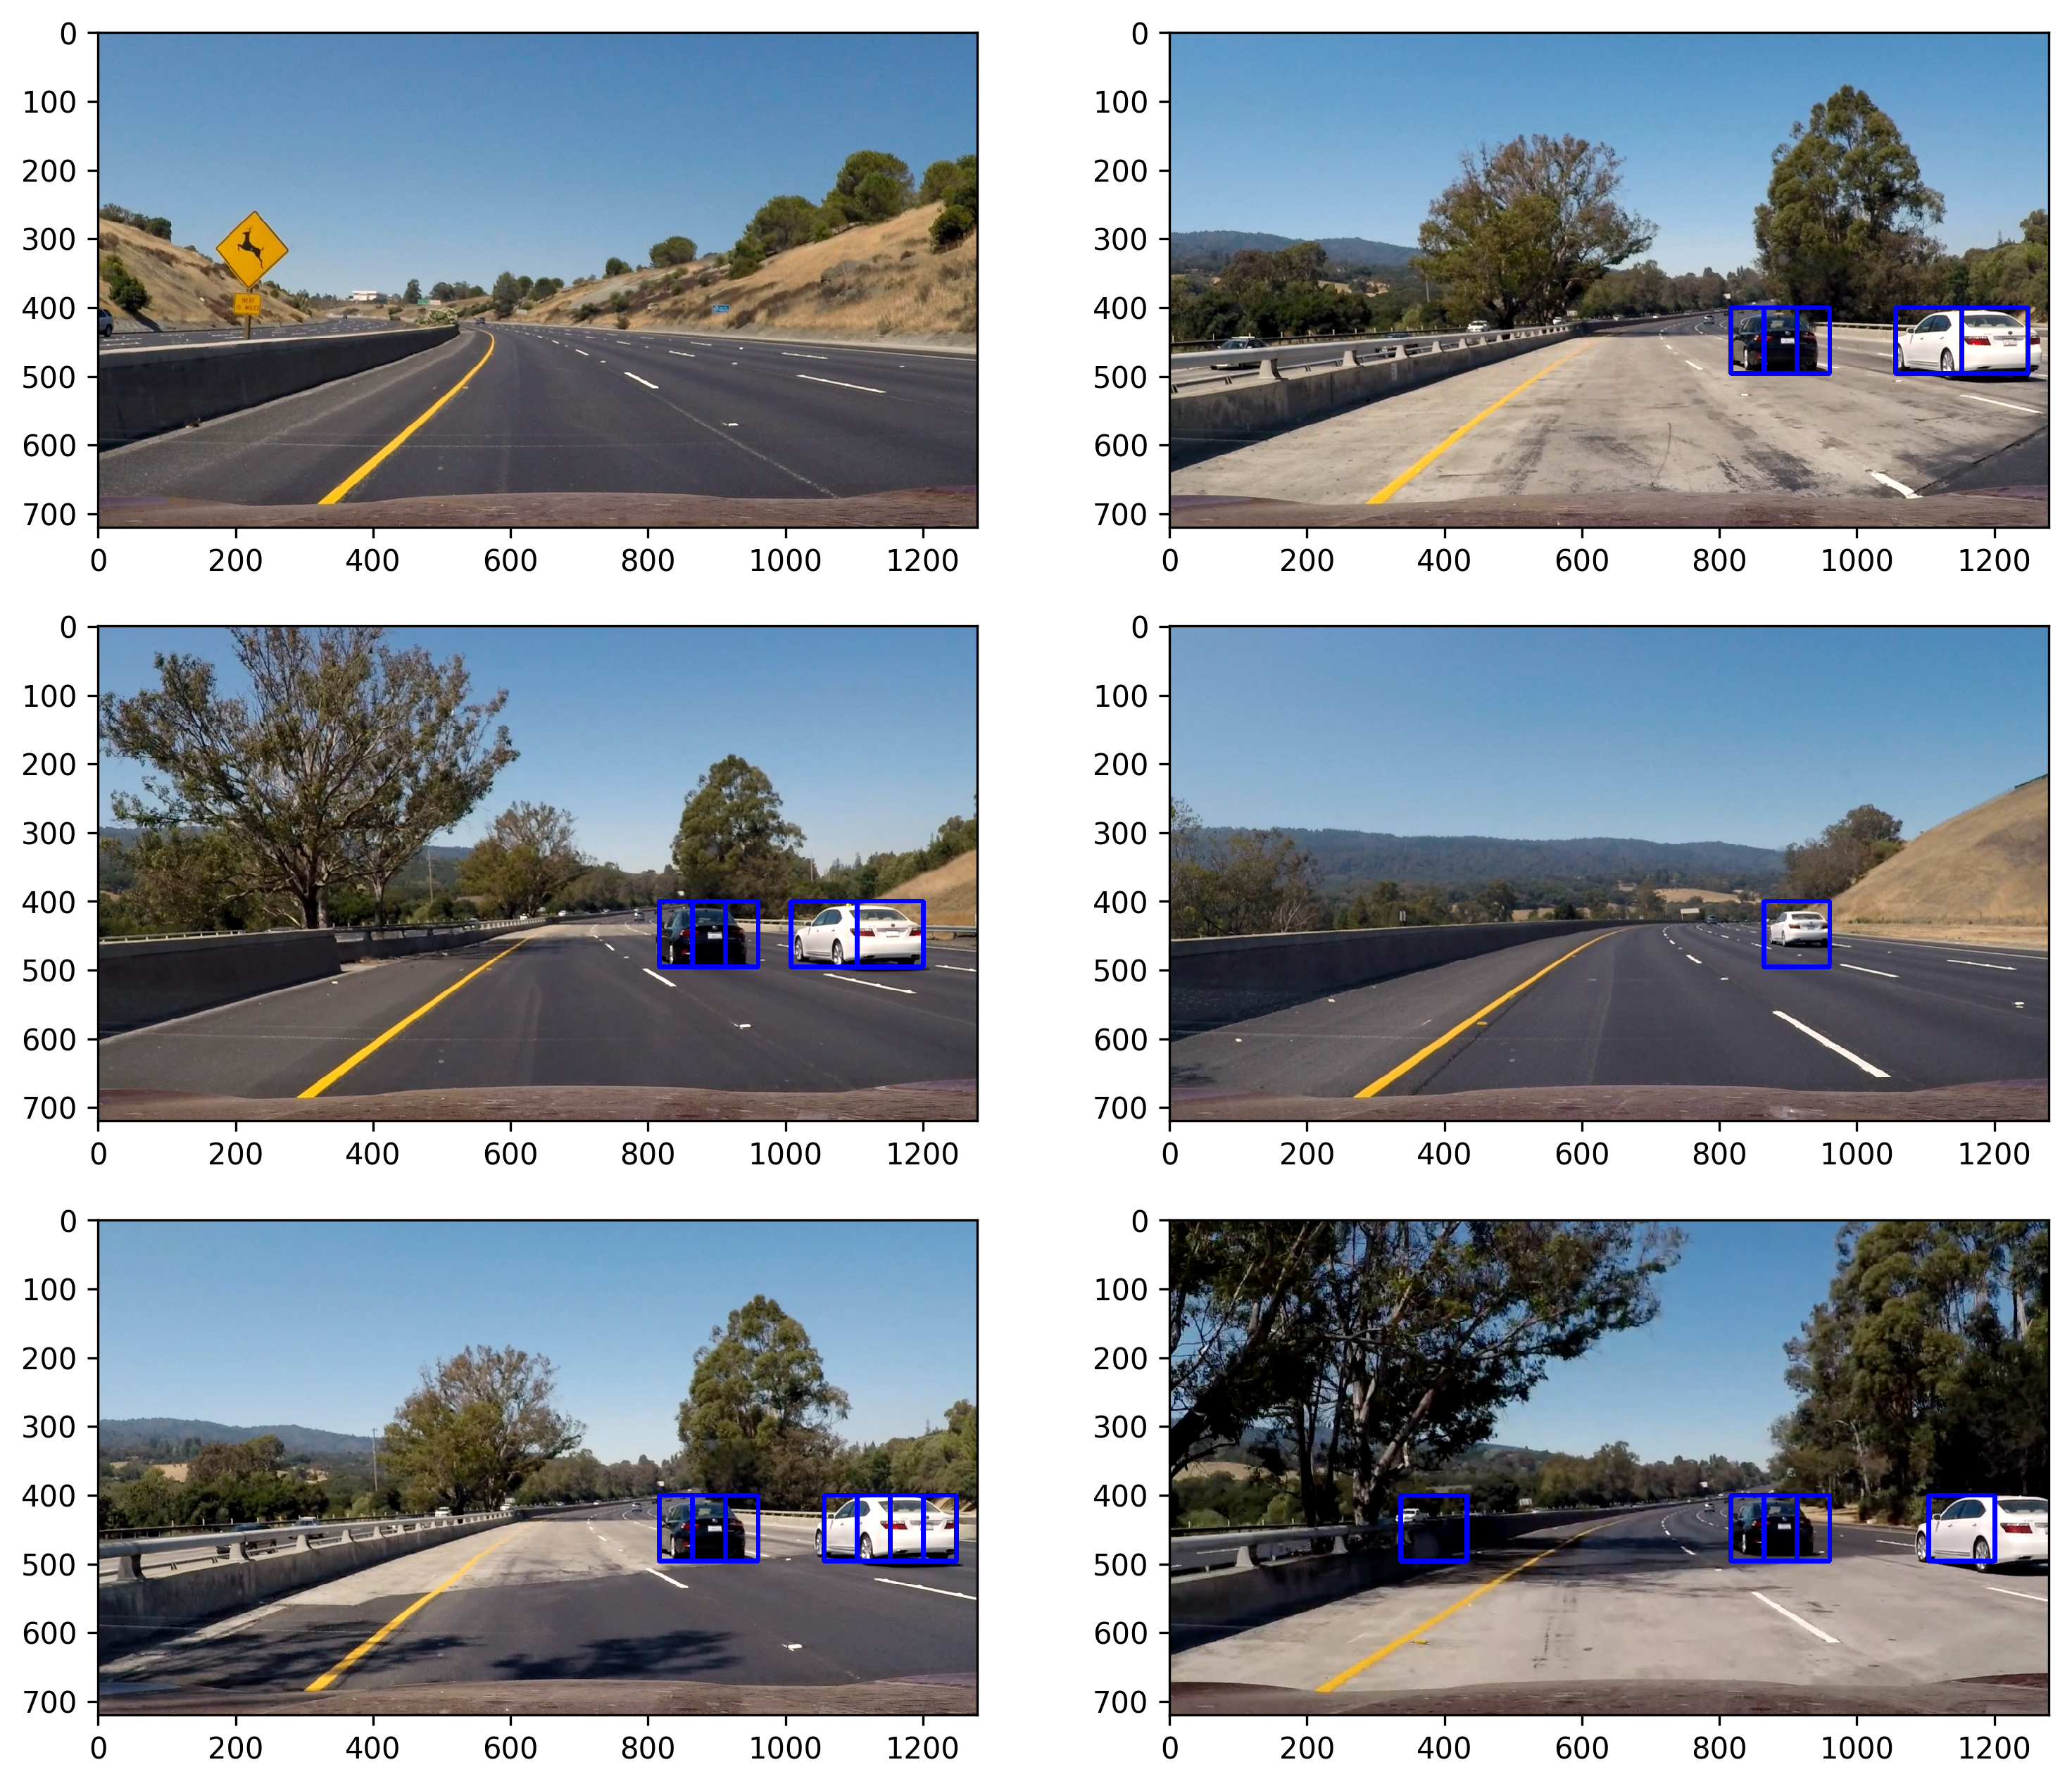

In [56]:
### TESTING CLASSIFIER PERFORMANCE AND WIN SEARCH/DRAW ON TEST IMAGES ###

searchpath = './test_images/*'
example_images = glob.glob(searchpath)
images = [] # hold images with window overlay for visualization
titles = [] # titles for visualization

y_start_stop = [400, 656] # min and max in y to search in slide_window()
overlap = 0.5
window_size = 96

for img_src in example_images:
    t1 = time.time()
    img = mpimg.imread(img_src)
    draw_img = np.copy(img)
    # scale '.jpg' to [0,1] to match PNG scale of training
    img = img.astype(np.float32)/255
    print(np.min(img), np.max(img))
    
    windows = slide_window(img.shape, x_start_stop=[None, None], y_start_stop=y_start_stop,
                           xy_window=(window_size,window_size), xy_overlap=(overlap,overlap))
    
    hot_windows = search_windows(img, windows, svc, scaler=X_scaler, color_space=color_space,
                spatial_size=spatial_size, hist_bins=hist_bins, orient=orient,
                pix_per_cell=pix_per_cell,cell_per_block=cell_per_block,
                hog_channel=hog_channel, spatial_feat=spatial_feat, hist_feat=hist_feat,
                hog_feat=hog_feat)
    
    window_img = draw_boxes(draw_img, hot_windows, color=(0,0,255), thick=6)
    images.append(window_img)
    titles.append('')
    print(time.time()-t1, 'seconds to process one image searching', len(windows),
          'windows')
fit = plt.figure(figsize=(12,18), dpi=300)
visualize(fig, 5, 2, images, titles)


0.386796236038208 secnds to run, total windows =  294
0.40442585945129395 secnds to run, total windows =  294
0.39968132972717285 secnds to run, total windows =  294
0.351576566696167 secnds to run, total windows =  294
0.4463183879852295 secnds to run, total windows =  294
0.4353153705596924 secnds to run, total windows =  294


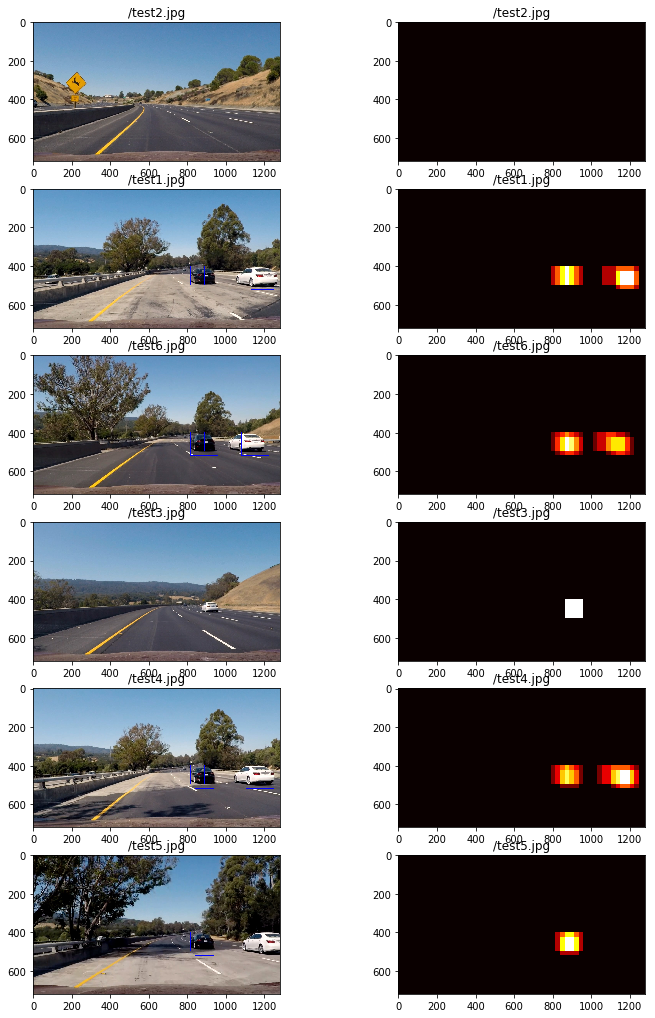

In [68]:
### TEST HOG BY WINDOW REGION FROM SINGLE FULL IMAGE HOG CALCULATION ### 
### VISUALIZE HEATMAP ###

# For visualizations
out_images = []
out_titles = []

# Consider a narrower swath in y
ystart = 400
ystop = 656
scale = 1.5

# Iterate over test images
for img_src in example_images:
    img_boxes = []
    t=time.time()
    count=0
    img = mpimg.imread(img_src)
    draw_img = np.copy(img)
    
    heatmap = np.zeros_like(img[:,:,0]) # Make a heatmap of zeros
    img_tosearch = img[ystart:ystop,:,:] # image sliced to window zone
    
    # convert to correct color mode for full img HOG
    ctrans_tosearch = color_mode(img_tosearch, color_space=color_space)
    # scaling '.jpg' to [0,1] to match PNG scale of training
    ctrans_tosearch = ctrans_tosearch.astype(np.float32)/255
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - 1   
    nyblocks = (ch1.shape[0] // pix_per_cell) - 1
    nfeat_per_block = orient*cell_per_block**2
    window = 64
    nblocks_per_window = (window // pix_per_cell) - 1
    cells_per_step = 2 # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            count += 1
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window,
                    xleft:xleft+window], (64,64))
            
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1,-1))
            test_predictions = svc.predict(test_features)
            
            if test_predictions == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img, (xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255))
                img_boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left:xbox_left+win_draw] += 1
                
    print(time.time()-t, 'secnds to run, total windows = ', count)
    
    out_images.append(draw_img)
    out_titles.append(img_src[-10:])
    out_images.append(heatmap)
    out_titles.append(img_src[-10:])

fig = plt.figure(figsize=(12,24))
visualize(fig, 8, 2, out_images, out_titles)


In [ ]:
# Iterate over test images
def find_cars(img, scale):
    
    draw_img = np.copy(img)
    # Make a heatmap of zeros
    heatmap = np.zeros_like(img[:,:,0])
    # scaling [0,1] to match PNG scale of training
    img = img.astype(np.float32)/255
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - 1   
    nyblocks = (ch1.shape[0] // pix_per_cell) - 1
    nfeat_per_block = orient*cell_per_block**2
    window = 64
    nblocks_per_window = (window // pix_per_cell) - 1
    cells_per_step = 2 # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window,
                    xleft:xleft+window], (64,64))
            
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1,-1))
            test_predictions = svc.predict(test_features)
            
            if test_predictions == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img, (xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255))
                img_boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left:xbox_left+win_draw] += 1
    
    return draw_img, heatmap

In [ ]:
from scipy.ndimage.measurements import label # check doc

#!! integrate heatmap over several frames before applying threshold 
def apply_threshold(heatmap, threshold):
    # Zero out pixels below threshold
    heatmap[heatmap <= threshold] = 0
    # Return threshold map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box base on minx/max and x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [ ]:
out_images = []
out_maps = []
ystart = 400
ystop = 656
scale = 1.5
# Iterate over test images
for img_src in example_images:
    img = mpimg.imread(img_src)
    out_img, heat_map = find_cars(img, scale)
    labels = label(heat_map)
    # Draw bounding boxes on a copy of the image
    draw_image = draw_labeled_bboxes(np.copy(img), labels)
    out_images.append(draw_image)
    out_images.append(heat_map)
    
fig = plt.figure(figsize=(12,24))
visualize(fig, 8, 2, out_images, out_titles)

In [ ]:
def process_image(img):
    out_image, heat_map = find_cars(img, scale)
    labels = label(heat_map)
    # Draw bounding boxes on a copy of the image
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

#test_output = 'testProcessed.mp4'
#clip = VideoFileClip('test_video.mp4')
test_output = 'projProcessed.mp4'
clip = VideoFileClip('project_video.mp4')
test_clip = clip.fl_image(process_image)
test_clip.write_videofile(test_output, audio=False)